# Load Dependencies

In [1]:
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import r2_score,mean_absolute_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook
random_seed = 2022

# Data Load

The details of the collected dataset

In [2]:
dataset = pd.read_csv('./datasets/dataset.csv',index_col=0)
physorg_desc_npz = np.load('./descriptors/physorg_desc.npz',allow_pickle=True)
physorg_react_desc = physorg_desc_npz['react_desc']
physorg_react_desc_name = physorg_desc_npz['react_desc_name']

ddG = dataset['ddG(kcal/mol)'].to_numpy()
dataset

,Biaryl,mole of Biaryl/mmol,Olefin,mole of Olefin/mmol,Product,Catalyst,Catalyst Concentration/%,TDG,TDG Concentration/%,Additive,...,Solvent Ratio,Volume of Solvent/ml,Reaction Time/h,Anode,Cathode,Current(mA),Temperature,Yield,ee,ddG(kcal/mol)
0,O=Cc1ccccc1-c1cccc2ccccc12,0.2,C=CC(=O)OCCCC,0.6,CCCCOC(=O)/C=C/c1ccc2ccccc2c1-c1ccccc1C=O,CC(=O)[O-].CC(=O)[O-].[Pd+2],10,CC(C)(C)[C@H](N)C(=O)O,20,CCCC[N+](CCCC)(CCCC)CCCC.F[P-](F)(F)(F)(F)F,...,NaN,4.5,14,grahite felt,Pt,1.5,60,0.57,0.99,3.507522
1,O=Cc1ccccc1-c1cccc2ccccc12,0.2,C=CC(=O)OCCCC,0.6,CCCCOC(=O)/C=C/c1ccc2ccccc2c1-c1ccccc1C=O,CC(=O)[O-].CC(=O)[O-].[Pd+2],10,CC(C)(C)[C@H](N)C(=O)O,20,CCCC[N+](CCCC)(CCCC)CCCC.F[P-](F)(F)(F)(F)F,...,NaN,4.5,14,grahite felt,Pt,0.0,60,0.20,0.99,3.507522
2,O=Cc1ccccc1-c1cccc2ccccc12,0.2,C=CC(=O)OCCCC,0.6,CCCCOC(=O)/C=C/c1ccc2ccccc2c1-c1ccccc1C=O,CC(=O)[O-].CC(=O)[O-].[Pd+2],5,CC(C)(C)[C@H](N)C(=O)O,10,CCCC[N+](CCCC)(CCCC)CCCC.F[P-](F)(F)(F)(F)F,...,NaN,4.5,14,grahite felt,Pt,1.5,60,0.38,0.99,3.507522
3,O=Cc1ccccc1-c1cccc2ccccc12,0.2,C=CC(=O)OCCCC,0.6,CCCCOC(=O)/C=C/c1ccc2ccccc2c1-c1ccccc1C=O,CC(=O)[O-].CC(=O)[O-].[Pd+2],5,CC(C)(C)[C@H](N)C(=O)O,10,CCCC[N+](CCCC)(CCCC)CCCC.F[P-](F)(F)(F)(F)F,...,NaN,4.5,14,grahite felt,Pt,4.0,60,0.33,0.99,3.507522
4,O=Cc1ccccc1-c1cccc2ccccc12,0.2,C=CC(=O)OCCCC,0.6,CCCCOC(=O)/C=C/c1ccc2ccccc2c1-c1ccccc1C=O,CC(=O)[O-].CC(=O)[O-].[Pd+2],10,CC(C)(C)[C@H](N)C(=O)O,20,CCCC[N+](CCCC)(CCCC)CCCC.F[P-](F)(F)(F)(F)F,...,NaN,4.5,14,grahite felt,Pt,2.0,60,0.41,0.99,3.507522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,O=Cc1ccccc1-c1cccc2ccccc12,0.2,C=Cc1ccccc1,0.6,O=Cc1ccccc1-c1c(/C=C/c2ccccc2)ccc2ccccc12,CC(=O)[O-].CC(=O)[O-].[Pd+2],10,CC(C)(C)[C@H](N)C(=O)O,20,[Li]OC(C)=O,...,NaN,4.5,16,grahite felt,Pt,1.5,60,0.19,0.86,1.714028
123,O=Cc1ccccc1-c1cccc2ccccc12,0.2,C=CC(=O)Oc1ccccc1-c1ccccc1,0.6,O=Cc1ccccc1-c1c(/C=C/C(=O)Oc2ccccc2-c2ccccc2)c...,CC(=O)[O-].CC(=O)[O-].[Pd+2],10,CC(C)(C)[C@H](N)C(=O)O,20,[Li]OC(C)=O,...,NaN,4.5,20,grahite felt,Pt,1.0,60,0.55,0.97,2.772852
124,O=Cc1ccccc1-c1cccc2ccccc12,0.2,C=CC(=O)OCC,0.6,CCOC(=O)/C=C/c1ccc2ccccc2c1-c1ccccc1C=O,CC(=O)[O-].CC(=O)[O-].[Pd+2],10,CC(C)(C)[C@H](N)C(=O)O,20,[Li]OC(C)=O,...,NaN,4.5,16,grahite felt,Pt,1.5,60,0.55,0.96,2.578852
125,O=Cc1ccc2ccccc2c1-c1ccccc1,0.2,C=CC(=O)OCCCC,0.6,CCCCOC(=O)/C=C/c1ccccc1-c1c(C=O)ccc2ccccc12,CC(=O)[O-].CC(=O)[O-].[Pd+2],10,CC(C)(C)[C@H](N)C(=O)O,20,[Li]OC(C)=O,...,NaN,4.5,20,grahite felt,Pt,1.5,60,0.49,0.97,2.772852


The physorg reaction encoding of the collected dataset

**Note:** All descriptors have been scaled with max-min scaler

In [3]:
physorg_df = pd.DataFrame(physorg_react_desc)
physorg_df.columns = physorg_react_desc_name
physorg_df

,q_HF_+1-a16-Imine-CH-GS,q_HF_+1-a15-Imine-AI-GS,q_HF_+1-a15-Imine-CH-R,q_HF_0-a15-Imine-CH-GS,q_HF_0-a15-Imine-AI-R,q_HF_0-a16-Imine-CH-GS,s_HF_0-a15-Imine-CH-R,q_HF_+1-a15-Imine-AI-R,s_HF_-1-a0-Olefin-AI-R,q_HF_0-a0-Olefin-AI-R,...,Sol XLogP3-AA 2,Sol Topological Polar Surface Area Å² 2,Sol Density (g/mL) 2,Sol Molar Volume (mL/mol) 2,Sol Refractive Index 2,Sol Dipole Moment (D) 2,Sol Melting Point (°C) 2,Sol Boiling Point (°C) 2,Temperature,Current
0,0.86655,0.877378,0.594308,0.483867,0.174023,0.686571,0.135257,0.68034,0.127431,0.767013,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.333333,0.375
1,0.86655,0.877378,0.594308,0.483867,0.174023,0.686571,0.135257,0.68034,0.127431,0.767013,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.333333,0.0
2,0.86655,0.877378,0.594308,0.483867,0.174023,0.686571,0.135257,0.68034,0.127431,0.767013,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.333333,0.375
3,0.86655,0.877378,0.594308,0.483867,0.174023,0.686571,0.135257,0.68034,0.127431,0.767013,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.333333,1.0
4,0.86655,0.877378,0.594308,0.483867,0.174023,0.686571,0.135257,0.68034,0.127431,0.767013,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.333333,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,0.86655,0.877378,0.594308,0.483867,0.174023,0.686571,0.135257,0.68034,0.418204,0.173284,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.333333,0.375
123,0.86655,0.877378,0.594308,0.483867,0.174023,0.686571,0.135257,0.68034,0.436106,0.828172,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.333333,0.25
124,0.86655,0.877378,0.594308,0.483867,0.174023,0.686571,0.135257,0.68034,0.156559,0.767181,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.333333,0.375
125,0.207299,0.160786,0.039966,1.0,0.523177,0.956873,0.918168,0.0,0.127431,0.767013,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.333333,0.375


## Select OOS Set

Compounds (biaryls, olefins and TDGs) have only one associated transformation in the dataset, and these transformations are selected out of the original dataset as the out-of-sample (OOS) test set.

In [4]:
biaryl_smiles = dataset['Biaryl'].to_list()
olefin_smiles = dataset['Olefin'].to_list()
tdg_smiles = dataset['TDG'].to_list()

biaryl_smi_count = {smi:biaryl_smiles.count(smi) for smi in biaryl_smiles}
olefin_smi_count = {smi:olefin_smiles.count(smi) for smi in olefin_smiles}
tdg_smi_count = {smi:tdg_smiles.count(smi) for smi in tdg_smiles}
pot_oos_biaryl_smi = [smi for smi in biaryl_smi_count if biaryl_smi_count[smi] == 1]
pot_oos_olefin_smi = [smi for smi in olefin_smi_count if olefin_smi_count[smi] == 1]
pot_oos_tdg_smi = [smi for smi in tdg_smi_count if tdg_smi_count[smi] == 1]

oos_index = []

for idx in range(len(dataset)):
    if biaryl_smiles[idx] in pot_oos_biaryl_smi or olefin_smiles[idx] in pot_oos_olefin_smi or\
       tdg_smiles[idx] in pot_oos_tdg_smi:
        oos_index.append(idx)
        
print(oos_index)

[15, 21, 31, 52, 56, 58, 59, 65, 96, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 120, 121, 122, 123, 124, 125, 126]


# Feature Selection with RFECV Algorithm

In [5]:
'''
The "test_index" is the index of the out-of-sample (OOS) test set, which should be excluded 
during the cross-validation procedure. 

OOS test set: 28 compounds (7 biaryls, 14 olefins and 7 TDGs) have only one associated 
transformation, and these transformations are selected out of the original dataset as 
the out-of-sample (OOS) test set.
'''
test_index = [15, 21, 31, 52, 56, 58, 59, 65, 96, 104, 105, 106, 107, 108, 109,
              110, 111, 112, 113, 114, 115, 120, 121, 122, 123, 124, 125, 126]

train_val_index = list(set(range(len(physorg_react_desc))) - set(test_index))

train_val_x,train_val_y = physorg_react_desc[train_val_index],ddG[train_val_index]
test_x,test_y = physorg_react_desc[test_index],ddG[test_index]

In [6]:
# The max_depth and n_estimators are identified by hyperparameters optimization procedure, which is demonstrated in Notebook 3.
model = ExtraTreesRegressor(max_depth=10,n_estimators=400,n_jobs=-1,random_state=random_seed)
cv = KFold(n_splits=10, shuffle=True, random_state=random_seed)
selector = RFECV(model, step=1, min_features_to_select=1,cv=cv, n_jobs=-1)
selector = selector.fit(train_val_x, train_val_y)
sel_index = np.where(selector.support_==True)[0]
print('----Reserved Descriptors----')
print('Size: %d'%len(sel_index))
print('Index of selected descriptors',sel_index)

----Reserved Descriptors----
Size: 29
Index of selected descriptors [  9  10  11  12  15  24  28  31  33  43  45  46  61  63  65  68  70  71
  72  73  75  79  83  92  95 102 106 107 118]


<IPython.core.display.Javascript object>


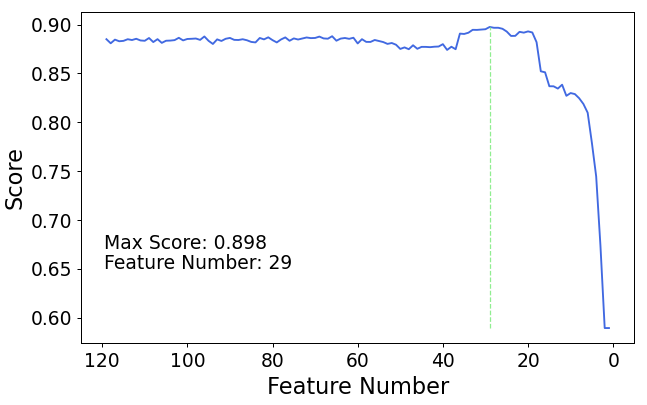

In [7]:
tick_fontsize = 15
label_fontsize = 18
fig = plt.figure(figsize=(8,5))
y_r2 = np.flipud(selector.grid_scores_)
x_1_index = [item+1 for item in list(range(len(y_r2)))]

plt.plot(x_1_index,y_r2,c='royalblue')
plt.plot([np.argmax(y_r2)+1,np.argmax(y_r2)+1],[np.min(y_r2),np.max(y_r2)],c='lightgreen',linewidth=1,
        linestyle='--')

init_range = [item+1 for item in list(range(len(y_r2)))]
reverse_range = list(range(len(y_r2),0,-1))
reverse_init_range_map = {rev:init for rev,init in zip(reverse_range,init_range)}
reverse_init_range_map[len(y_r2)+1] = 0
#reverse_init_range_map[50] = len(y_r2)+1-50
reverse_init_range_map[0] = len(y_r2)+1
num_range = list(range(120,-10,-20))

plt.xticks([reverse_init_range_map[item] for item in num_range],
           list(map(str,num_range)),
           fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)

plt.text(0.5,0.67,'Max Score: %.3f'%np.max(y_r2),fontsize=tick_fontsize)
plt.text(0.5,0.65,'Feature Number: %d'%(len(y_r2) - np.argmax(y_r2)),fontsize=tick_fontsize)

plt.xlabel('Feature Number',fontsize=label_fontsize)
plt.ylabel('Score',fontsize=label_fontsize)

plt.tick_params(bottom='on',left='on')
plt.tight_layout()

# Regression Performance

## Cross-Validation

In [8]:
val_Y = []
val_P = []
kfold = KFold(n_splits=10, shuffle=True, random_state=random_seed)
for train_idx,val_idx in kfold.split(train_val_x):
    train_x,val_x = train_val_x[:,sel_index][train_idx],train_val_x[:,sel_index][val_idx]
    train_y,val_y = train_val_y[train_idx],train_val_y[val_idx]
    val_P_ = []
    for try_ in range(10): 
        model.fit(train_x,train_y)
        val_p = model.predict(val_x)
        val_P_.append(val_p)
    val_P_ = np.mean(val_P_,axis=0)
    val_P.append(val_P_)
    val_Y.append(val_y)
val_P = np.concatenate(val_P)
val_Y = np.concatenate(val_Y)
mae = mean_absolute_error(val_Y,val_P)
r2 = r2_score(val_Y,val_P)
pearson_r,_ = pearsonr(val_Y,val_P)

print("MAE: %.4f, R2: %.4f, Pearson R: %.4f"%(mae,r2,pearson_r))

MAE: 0.2359, R2: 0.9091, Pearson R: 0.9535


<IPython.core.display.Javascript object>


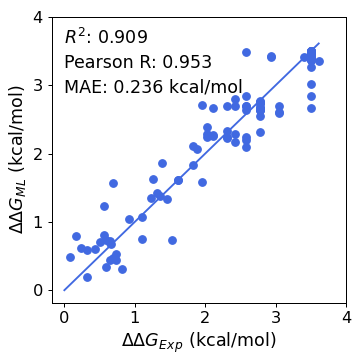

In [9]:
plt.figure(figsize=(4.5,4.5))

plt.scatter(val_Y,val_P,c='royalblue')

plt.text(0,3.6,'$R^2$: %.3f'%r2_score(val_Y,val_P),fontsize=14)
plt.text(0,3.25,'Pearson R: %.3f'%pearsonr(val_Y,val_P)[0],fontsize=14)
plt.text(0,2.9,'MAE: %.3f kcal/mol'%mean_absolute_error(val_Y,val_P),fontsize=14)

plt.plot([0,ddG.max()],[0,ddG.max()],c='royalblue')
plt.xlabel('$\Delta$$\Delta$$G_E$$_x$$_p$ (kcal/mol)',fontsize=14)
plt.ylabel('$\Delta$$\Delta$$G_M$$_L$ (kcal/mol)',fontsize=14)
plt.xticks([0,1,2,3,4],list(map(str,[0,1,2,3,4])),fontsize=13)
plt.yticks([0,1,2,3,4],list(map(str,[0,1,2,3,4])),fontsize=13)

plt.tick_params(bottom='on',left='on')
plt.tight_layout()

## Out-of-Sample Test Set

In [10]:
test_P = []
feature_importance = []
for _ in range(10):
    model.fit(train_val_x[:,sel_index],train_val_y)
    feature_importance.append(model.feature_importances_)
    test_p = model.predict(test_x[:,sel_index])
    test_P.append(test_p)
test_p = np.mean(test_P,axis=0)
feature_importance = np.mean(feature_importance,axis=0)
sel_feature_names = np.array(physorg_react_desc_name)[sel_index]
sorted_feature_index = np.argsort(feature_importance)
importance_desc_names = sel_feature_names[sorted_feature_index]
importance_of_sel_desc = feature_importance[sorted_feature_index]

r2 = r2_score(test_y,test_p)
pearson_r,_ = pearsonr(test_y,test_p)
mae = mean_absolute_error(test_y,test_p)
print("MAE: %.4f, R2: %.4f, Pearson R: %.4f"%(mae,r2,pearson_r))

MAE: 0.3738, R2: 0.8219, Pearson R: 0.9254


<IPython.core.display.Javascript object>


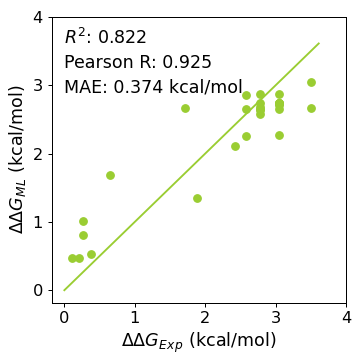

In [11]:
plt.figure(figsize=(4.5,4.5))

plt.scatter(test_y,test_p,c='yellowgreen')
plt.text(0,3.6,'$R^2$: %.3f'%r2_score(test_y,test_p),fontsize=14)
plt.text(0,3.25,'Pearson R: %.3f'%pearsonr(test_y,test_p)[0],fontsize=14)
plt.text(0,2.9,'MAE: %.3f kcal/mol'%mean_absolute_error(test_y,test_p),fontsize=14)
plt.plot([0,ddG.max()],[0,ddG.max()],c='yellowgreen')
plt.xlabel('$\Delta$$\Delta$$G_E$$_x$$_p$ (kcal/mol)',fontsize=14)
plt.ylabel('$\Delta$$\Delta$$G_M$$_L$ (kcal/mol)',fontsize=14)
plt.xticks([0,1,2,3,4],list(map(str,[0,1,2,3,4])),fontsize=13)
plt.yticks([0,1,2,3,4],list(map(str,[0,1,2,3,4])),fontsize=13)
plt.tick_params(bottom='on',left='on')
plt.tight_layout()

### Feature Ranking

In [12]:
desc_importance_colors = []
for name in importance_desc_names:
    if 'Imine' in name:
        desc_importance_colors.append('lightgreen')
    elif "Olefin" in name:
        desc_importance_colors.append("bisque")
    elif "TDG" in name:
        desc_importance_colors.append('lightblue')
    else:
        desc_importance_colors.append('lightgray')

<IPython.core.display.Javascript object>


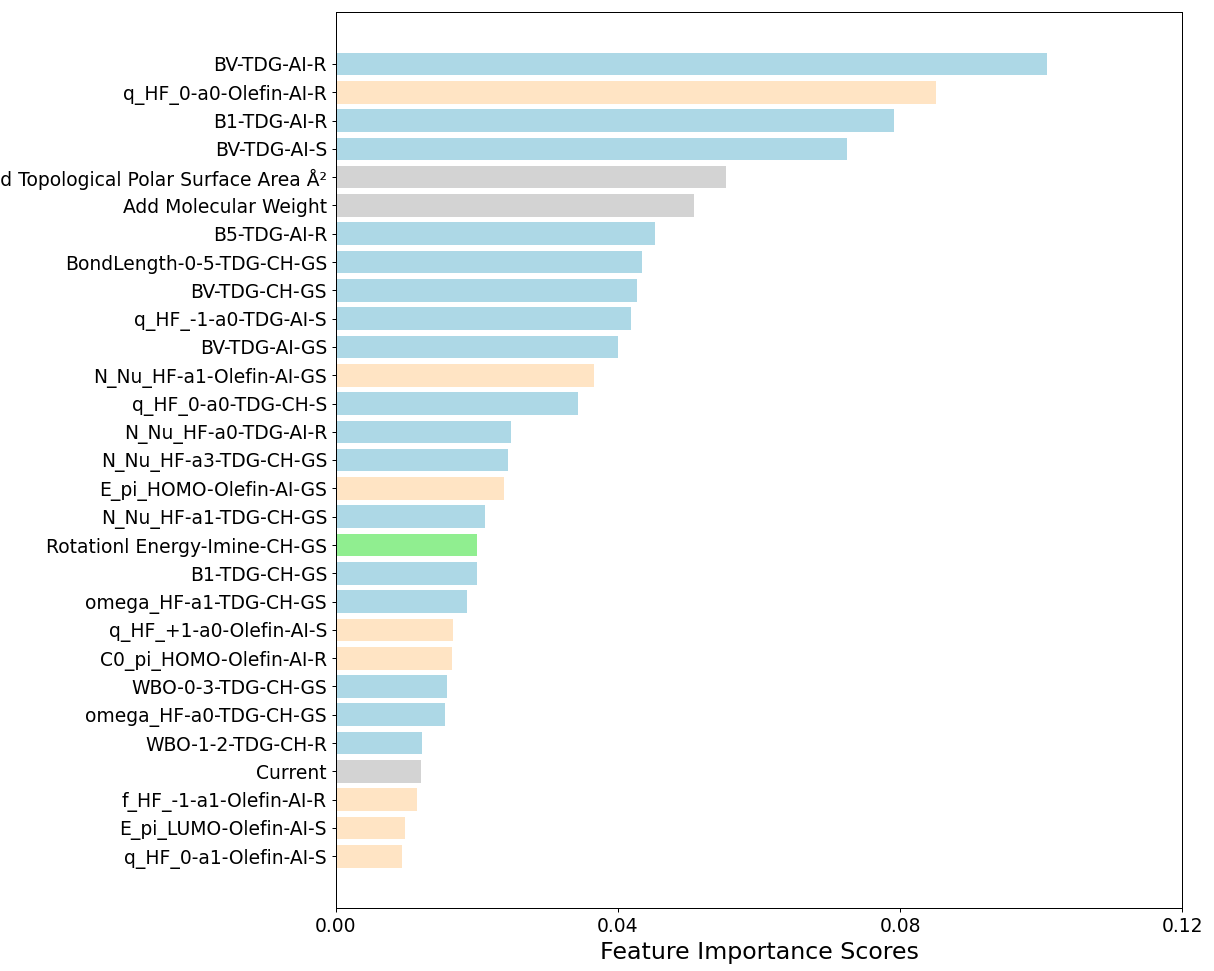

In [13]:
fig = plt.figure(figsize=(15,12))

plt.barh(importance_desc_names, importance_of_sel_desc, color=desc_importance_colors,align='center')
plt.xlabel('Feature Importance Scores',fontsize=19)
plt.xticks([0,0.04,0.08,0.12],["0.00","0.04","0.08",'0.12'],fontsize=15)
plt.yticks(fontsize=15)
plt.tick_params(left='on',bottom='on')
plt.tight_layout()
print()

## External Exerimental Tests

The details of the external experimental test set

In [14]:
external_test_set = pd.read_csv('./datasets/external_test_set.csv',index_col=0)
ext_ddG = external_test_set['ddG']
external_test_set

,Biaryl,Olefin,Ligand,Additive,Solvent,Current,Ligand Concentration,Additive eq,Temperature,ddG,ee
0,Cc1ccc(C=O)c(-c2cccc3ccccc23)c1,C=CC(=O)OCCCC,CC(C)(C)[C@H](N)C(=O)O,[Li]OC(C)=O,CC(=O)O,1,20,2,60,2.772852,0.97
1,O=Cc1cc(Cl)ccc1-c1cccc2ccccc12,C=CC(=O)OCCCC,CC(C)(C)[C@H](N)C(=O)O,[Li]OC(C)=O,CC(=O)O,1,20,2,60,2.772852,0.97
2,N#Cc1ccc(-c2cccc3ccccc23)c(C=O)c1,C=CC(=O)OCCCC,CC(C)(C)[C@H](N)C(=O)O,[Li]OC(C)=O,CC(=O)O,1,20,2,60,3.044882,0.98
3,O=Cc1cc(O)ccc1-c1cccc2ccccc12,C=CC(=O)OCCCC,CC(C)(C)[C@H](N)C(=O)O,[Li]OC(C)=O,CC(=O)O,1,20,2,60,3.044882,0.98
4,O=Cc1ccccc1-c1cccc2ccccc12,C=CC(=O)OCCCC,N[C@@H](Cc1ccc(I)cc1)C(=O)O,[Li]OC(C)=O,CC(=O)O,1,20,2,60,0.439521,0.32
5,O=Cc1ccccc1-c1cccc2ccccc12,C=CC(=O)OCCCC,COC(=O)[C@@H](N)Cc1ccccc1,[Li]OC(C)=O,CC(=O)O,1,20,2,60,0.186764,0.14
6,O=Cc1ccccc1-c1cccc2ccccc12,C=CC(=O)OC(C)(C)C,CC(C)(C)[C@H](N)C(=O)O,[Li]OC(C)=O,CC(=O)O,1,20,2,60,2.578852,0.96
7,O=Cc1ccccc1-c1cccc2ccccc12,C=CC(=O)Oc1c(F)c(F)c(F)c(F)c1F,CC(C)(C)[C@H](N)C(=O)O,[Li]OC(C)=O,CC(=O)O,1,20,2,60,3.044882,0.98
8,O=Cc1ccccc1-c1cccc2ccccc12,C=C(C)C(=O)OC,CC(C)(C)[C@H](N)C(=O)O,[Li]OC(C)=O,CC(=O)O,1,20,2,60,2.105886,0.92
9,O=Cc1ccccc1-c1cccc2ccccc12,C=C(C)C(=O)OCC,CC(C)(C)[C@H](N)C(=O)O,[Li]OC(C)=O,CC(=O)O,1,20,2,60,2.024378,0.91


The physorg reaction encoding of the external experimental test set

**Note:** All descriptors have been scaled with max-min scaler

In [15]:
external_physorg_desc = np.load('./descriptors/physorg_for_external_test_set.npz',allow_pickle=True)
ext_physorg_desc = external_physorg_desc['react_desc']
ext_physorg_desc_name = external_physorg_desc['react_desc_name']

ext_physorg_df = pd.DataFrame(ext_physorg_desc)
ext_physorg_df.columns = physorg_react_desc_name
ext_physorg_df


,q_HF_+1-a16-Imine-CH-GS,q_HF_+1-a15-Imine-AI-GS,q_HF_+1-a15-Imine-CH-R,q_HF_0-a15-Imine-CH-GS,q_HF_0-a15-Imine-AI-R,q_HF_0-a16-Imine-CH-GS,s_HF_0-a15-Imine-CH-R,q_HF_+1-a15-Imine-AI-R,s_HF_-1-a0-Olefin-AI-R,q_HF_0-a0-Olefin-AI-R,...,Sol XLogP3-AA 2,Sol Topological Polar Surface Area Å² 2,Sol Density (g/mL) 2,Sol Molar Volume (mL/mol) 2,Sol Refractive Index 2,Sol Dipole Moment (D) 2,Sol Melting Point (°C) 2,Sol Boiling Point (°C) 2,Temperature,Current
0,0.747931,0.779129,0.578974,0.44669,0.168011,0.642867,0.128531,0.668741,0.127431,0.767013,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.333333,0.25
1,0.782475,0.788718,0.595265,0.513788,0.203449,0.742391,0.20043,0.656335,0.127431,0.767013,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.333333,0.25
2,0.904957,0.890819,0.612733,0.730713,0.413068,0.895139,0.199225,0.696119,0.127431,0.767013,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.333333,0.25
3,0.658158,0.682999,0.513003,0.352685,0.027685,0.624117,0.203938,0.580308,0.127431,0.767013,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.333333,0.25
4,0.86655,0.877378,0.594308,0.483867,0.174023,0.686571,0.135257,0.68034,0.127431,0.767013,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.333333,0.25
5,0.86655,0.877378,0.594308,0.483867,0.174023,0.686571,0.135257,0.68034,0.127431,0.767013,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.333333,0.25
6,0.86655,0.877378,0.594308,0.483867,0.174023,0.686571,0.135257,0.68034,0.123078,0.731704,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.333333,0.25
7,0.86655,0.877378,0.594308,0.483867,0.174023,0.686571,0.135257,0.68034,0.264463,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.333333,0.25
8,0.86655,0.877378,0.594308,0.483867,0.174023,0.686571,0.135257,0.68034,0.261834,0.51614,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.333333,0.25
9,0.86655,0.877378,0.594308,0.483867,0.174023,0.686571,0.135257,0.68034,0.273909,0.511926,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.333333,0.25


<IPython.core.display.Javascript object>


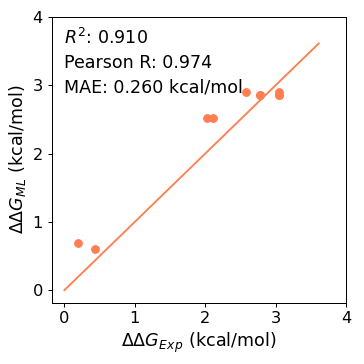

In [16]:
model.fit(physorg_react_desc[:,sel_index],ddG)
ext_pred = model.predict(ext_physorg_desc[:,sel_index])

ext_r2 = r2_score(ext_ddG,ext_pred)
ext_mae = mean_absolute_error(ext_ddG,ext_pred)
ext_pearson_r = pearsonr(ext_ddG,ext_pred)[0]

plt.figure(figsize=(4.5,4.5))

plt.scatter(ext_ddG,ext_pred,c='coral')

plt.text(0,3.6,'$R^2$: %.3f'%ext_r2,fontsize=14)
plt.text(0,3.25,'Pearson R: %.3f'%ext_pearson_r,fontsize=14)
plt.text(0,2.9,'MAE: %.3f kcal/mol'%ext_mae,fontsize=14)

plt.plot([0,ddG.max()],[0,ddG.max()],c='coral')
plt.xlabel('$\Delta$$\Delta$$G_E$$_x$$_p$ (kcal/mol)',fontsize=14)
plt.ylabel('$\Delta$$\Delta$$G_M$$_L$ (kcal/mol)',fontsize=14)
plt.xticks([0,1,2,3,4],list(map(str,[0,1,2,3,4])),fontsize=13)
plt.yticks([0,1,2,3,4],list(map(str,[0,1,2,3,4])),fontsize=13)
plt.tick_params(bottom='on',left='on')

plt.tight_layout()